# OKX Dataset

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime

data_folder = "C:\\Users\\shyen\\fasanara-digital\\data\\"

df1 = pd.read_csv(data_folder + "okex_book_snapshot_25_2022-09-28_BTC-USDT.csv")
df2 = pd.read_csv(data_folder + "okex_trades_2022-09-28_BTC-USDT.csv")

In [2]:
df1 = df1.drop(['exchange', 'symbol', 'local_timestamp'], axis=1)
df2 = df2.filter(items=('timestamp', 'side', 'price', 'amount'))

In [4]:
df2

,timestamp,side,price,amount
0,1664323200251000,buy,19080.1,0.052417
1,1664323200251000,buy,19080.1,0.011386
2,1664323200251000,buy,19080.1,0.020000
3,1664323200251000,buy,19080.4,0.262084
4,1664323200251000,buy,19080.5,0.117197
...,...,...,...,...
313201,1664409581336000,buy,19414.0,0.128785
313202,1664409581336000,buy,19414.0,0.136770
313203,1664409581336000,buy,19415.2,0.010768
313204,1664409581747000,buy,19414.2,0.066343


## Construct Target Value

### Construct average transaction price (5 seconds)

In [4]:
df2_1 = df2.copy()
df2_1['direction'] = df2_1['side'].apply(lambda x: 1 if x == 'buy' else -1)
df2_1 = df2_1.drop('side', axis=1)

In [5]:
df2_1['ms'] = df2_1.timestamp.apply(lambda x: int(str(x)[:13]))
df2_1['datetime_ms'] = pd.to_datetime(df2_1['ms'], unit = 'ms')
df2_1 = df2_1.filter(items=('ms', 'datetime_ms', 'price', 'amount', 'direction'))

In [6]:
df2_2 = df2_1.copy()
df2_2 = df2_2.set_index('datetime_ms')
lag = "5s"
df2_2 = df2_2[['price']].resample(lag).mean().reset_index()
df2_2 = df2_2.rename(columns={'datetime_ms':'T', 'price': 'avgPx'})

### Construct mid price

In [7]:
df1_1 = df1[['timestamp', 'asks[0].price', 'asks[0].amount', 'bids[0].price', 'bids[0].amount']]
df1_1 = df1_1.rename(columns={'asks[0].price':'best_ask_price', 'asks[0].amount':'best_ask_size', 'bids[0].price':'best_bid_price', 'bids[0].amount':'best_bid_size'})

In [8]:
df1_1['ms'] = df1_1.timestamp.apply(lambda x: int(str(x)[:13]))
df1_1['datetime_ms'] = pd.to_datetime(df1_1['ms'], unit = 'ms')
df1_1 = df1_1.filter(items=('ms', 'datetime_ms', 'best_ask_price', 'best_ask_size', 'best_bid_price', 'best_bid_size'))

In [9]:
df1_2 = df1_1.copy()
df1_2['midPx'] = (df1_2['best_ask_price']+df1_2['best_bid_price'])/2
df1_2 = df1_2.set_index('datetime_ms')

In [10]:
# shift by one
lag = "100ms"
df1_2 = df1_2[['midPx']].resample(lag).last().shift(1).reset_index()
df1_2 = df1_2.rename(columns={'datetime_ms':'T'})
# just before time T, the mid price

### Construct Target Value: Average Price Return of next 5 seconds

In [11]:
## as_of merge and forward fill
temp = pd.merge_asof(df2_2, df1_2, on='T').fillna(method='ffill')
temp['return'] = temp['avgPx']/temp['midPx'] - 1
temp = temp.dropna()

In [12]:
target = temp[['T','return']]
target = target.reset_index(drop=True)

In [13]:
target.head(5)

,T,return
0,2022-09-28 00:00:05,0.000017
1,2022-09-28 00:00:10,0.000021
2,2022-09-28 00:00:15,0.000050
3,2022-09-28 00:00:20,-0.000004
4,2022-09-28 00:00:25,-0.000023


Text(0.5, 1.0, 'Histogram of Target Values')

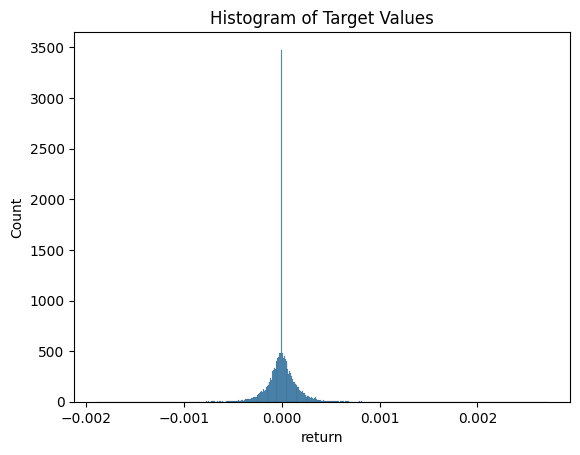

In [14]:
sns.histplot(target['return'])
plt.title("Histogram of Target Values")

Text(0.5, 1.0, 'Transaction return with 5-seconds time horizon')

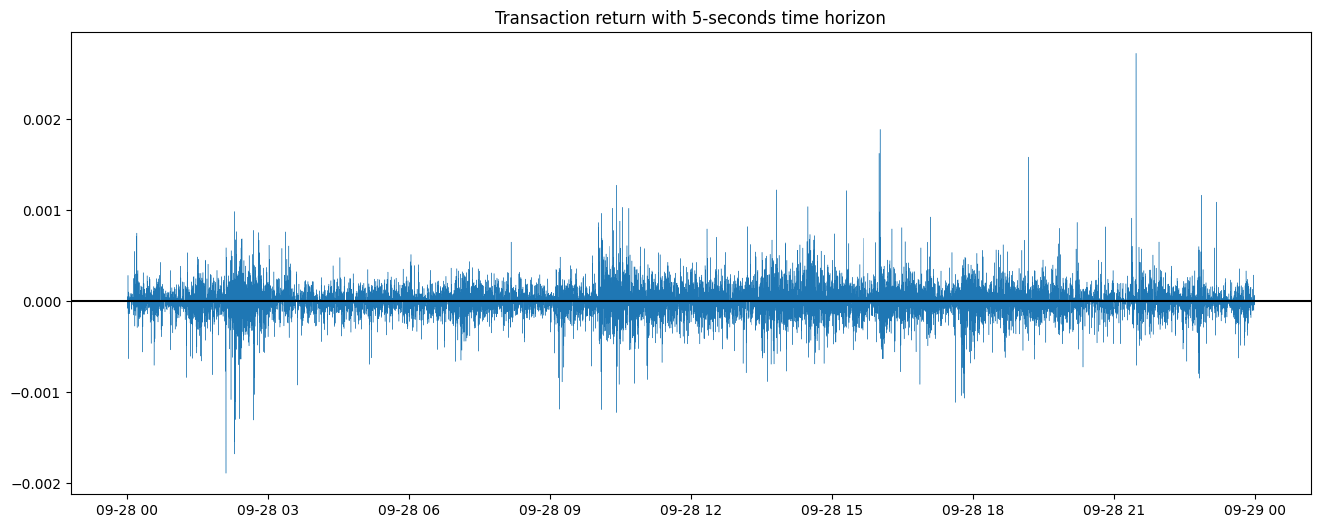

In [15]:
plt.figure(figsize=(16,6))
plt.plot(target['T'], target['return'], linewidth=0.3)
plt.axhline(y=0, c='black')
plt.title('Transaction return with 5-seconds time horizon')

## Construct Features

### 1. Transaction Imbalance

In [16]:
lag = "500ms"
temp = df2_1.copy()

In [17]:
temp['signed_vol'] = temp['amount']*temp['direction']
temp = temp.set_index('datetime_ms')
## resampling and shifting
temp = temp[['signed_vol', 'amount']].resample(lag).sum().shift(1).reset_index()

## define transaction imbalance
temp['txn_imbalance_lag_1'] = temp['signed_vol']/temp['amount']

In [18]:
## construct lagged values (have to be done before as_of merge)
for i in range(2,11):
    s = 'txn_imbalance_lag_' + str(i)
    temp[s] = temp['txn_imbalance_lag_1'].shift(i-1)
## remove NaN
temp = temp.iloc[10:]

In [19]:
temp1 = temp.drop(["signed_vol", "amount"], axis = 1)
temp1 = temp1.fillna(0)
temp1 = temp1.rename(columns={'datetime_ms':'T'})

## as-of merge to fit into target table
temp1 = pd.merge_asof(target, temp1, on='T')
## define feature table
transaction_imbalance = temp1.drop('return', axis=1)

Text(0.5, 1.0, 'Transaction Imbalance with lag 500ms')

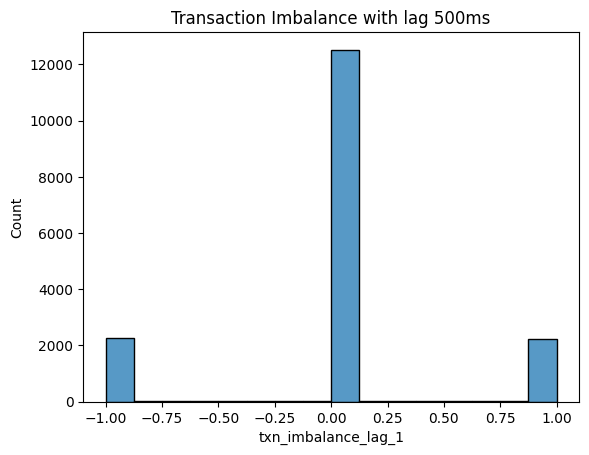

In [20]:
sns.histplot(transaction_imbalance['txn_imbalance_lag_1'])
plt.title("Transaction Imbalance with lag " + lag)

### 2. Past Return

In [21]:
lag = "250ms"
temp = df2_1.copy()
temp = temp.set_index('datetime_ms')
temp = temp[['price']].resample(lag).mean().shift(1).reset_index()
temp = temp.rename(columns={'price':'avgPx_lag_1', 'datetime_ms':'T'})

In [22]:
temp1 = df2_1.copy()
temp1 = temp1.set_index('datetime_ms')
temp1 = temp1[['price']].resample(lag).last().shift(1).reset_index()
temp1 = temp1.rename(columns={'price':'lastPx_lag_1', 'datetime_ms':'T'})

In [23]:
temp = temp.merge(temp1, how='left', on='T')
temp['past_return_lag_1'] = 1 - temp['avgPx_lag_1']/temp['lastPx_lag_1']
temp = temp.iloc[1:].fillna(0)

In [24]:
## construct lagged values (have to be done before as_of merge)
for i in range(2,11):
    s = 'past_return_lag_' + str(i)
    temp[s] = temp['past_return_lag_1'].shift(i-1)
## remove NaN
temp = temp.iloc[9:]

In [25]:
temp1 = temp.drop(["avgPx_lag_1", "lastPx_lag_1"], axis=1)

## as-of merge to fit into target table
temp1 = pd.merge_asof(target, temp1, on='T')
## define feature table
past_return = temp1.drop('return', axis=1)

Text(0.5, 1.0, 'Histogram of past return with lag 250ms')

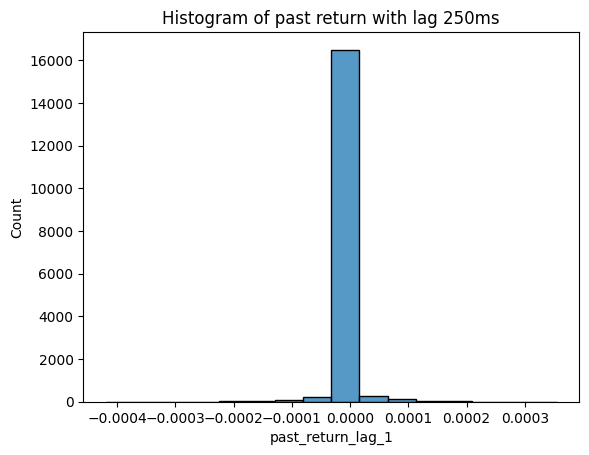

In [26]:
sns.histplot(past_return.past_return_lag_1)
plt.title('Histogram of past return with lag ' + lag)

### 3. LOB Imbalance

In [27]:
lag = "100ms"
temp = df1_1.copy()
temp = temp.set_index('datetime_ms')
temp['lob_imb'] = (temp['best_ask_size'] - temp['best_bid_size'])/(temp['best_ask_size'] + temp['best_bid_size'])

In [28]:
# resampling and shift by one
temp = temp[['lob_imb']].resample(lag).mean().shift(1).reset_index()
temp = temp.rename(columns={'lob_imb':'lob_imb_lag_1', 'datetime_ms':'T'})
temp = temp.fillna(method='ffill')

In [29]:
## construct lagged values (have to be done before as_of merge)
for i in range(2,11):
    s = 'lob_imb_lag_' + str(i)
    temp[s] = temp['lob_imb_lag_1'].shift(i-1)
## remove NaN
temp = temp.iloc[10:]

In [30]:
lob_imbalance = pd.merge_asof(target, temp, on='T')
## define feature table
lob_imbalance = lob_imbalance.drop('return', axis=1)

### 4. Lambda: transaction price change in the interval relative to total volume

In [31]:
lag = "500ms"
temp = df2_1.copy()
temp = temp.set_index('datetime_ms')
temp = temp[['price']].resample(lag).agg(['first', 'last']).shift(1).reset_index()
# flatten multi-index columns
temp.columns = temp.columns.to_flat_index()
# rename columns
temp.columns = ['T', 'firstPx_lag_1', 'lastPx_lag_1']

In [32]:
lag = "500ms"
temp1 = df2_1.copy()
temp1 = temp1.set_index('datetime_ms')
temp1 = temp1[['amount']].resample(lag).sum().shift(1).reset_index()
temp1 = temp1.rename(columns={'amount':'totVol_lag_1', 'datetime_ms':'T'})

In [33]:
temp = temp.merge(temp1, how='left', on='T')
## construct lambda
temp['lambda_lag_1'] = (temp['lastPx_lag_1']-temp['firstPx_lag_1'])/temp['totVol_lag_1']
## remove first row (from shifting)
temp = temp.iloc[1:]
# fill NaN by 0 because no price change
temp = temp.fillna(0)

In [34]:
## construct lagged values (have to be done before as_of merge)
for i in range(2,11):
    s = 'lambda_lag_' + str(i)
    temp[s] = temp['lambda_lag_1'].shift(i-1)
## remove NaN
temp = temp.iloc[9:]

In [35]:
px_change_rel_vol = pd.merge_asof(target, temp, on='T')
px_change_rel_vol = px_change_rel_vol.drop(["firstPx_lag_1", "lastPx_lag_1", "return", "totVol_lag_1"], axis=1)

### 5. Quoted Spread

In [36]:
lag = "100ms"
temp = df1_1.copy()
temp = temp.set_index('datetime_ms')
temp['quoted_spread_lag_1'] = 2*(temp['best_ask_price'] - temp['best_bid_price'])/(temp['best_ask_price'] + temp['best_bid_price'])

In [37]:
# resampling and shift by one
temp = temp[['quoted_spread_lag_1']].resample(lag).mean().shift(1).reset_index()
temp = temp.rename(columns={'datetime_ms':'T'})
temp = temp.fillna(method='ffill')

In [38]:
## construct lagged values (have to be done before as_of merge)
for i in range(2,11):
    s = 'quoted_spread_lag_' + str(i)
    temp[s] = temp['quoted_spread_lag_1'].shift(i-1)
## remove NaN
temp = temp.iloc[10:]

In [39]:
quoted_spread = pd.merge_asof(target, temp, on='T')
## define feature table
quoted_spread = quoted_spread.drop('return', axis=1)

### 6. Number of Transactions &
### 7. Immediacy: average time between successive transactions

In [40]:
# a bit longer look back otherwise too many zeros
lag = "250ms"

temp = df2_1.copy()
temp = temp.set_index('datetime_ms')
temp = temp[['direction']].resample(lag).count().shift(1).reset_index()

In [41]:
temp = temp.rename(columns={'direction':'numTrade_lag_1', 'datetime_ms':'T'})
temp = temp.iloc[1:]

In [42]:
temp['immediacy_lag_1'] = 250/temp['numTrade_lag_1']
temp.replace([np.inf, -np.inf], 250, inplace=True)

In [43]:
## construct lagged values (have to be done before as_of merge)
for i in range(2,11):
    s = 'numTrade_lag_' + str(i)
    temp[s] = temp['numTrade_lag_1'].shift(i-1)
    s = 'immediacy_lag_' + str(i)
    temp[s] = temp['immediacy_lag_1'].shift(i-1)
## remove NaN
temp = temp.iloc[9:]

In [44]:
# check for infinite values
np.isinf(temp).values.sum()

0

In [45]:
intensity = pd.merge_asof(target, temp, on='T')
## define feature table
intensity = intensity.drop('return', axis=1)

Text(0.5, 0, 'Average time between successive transactions')

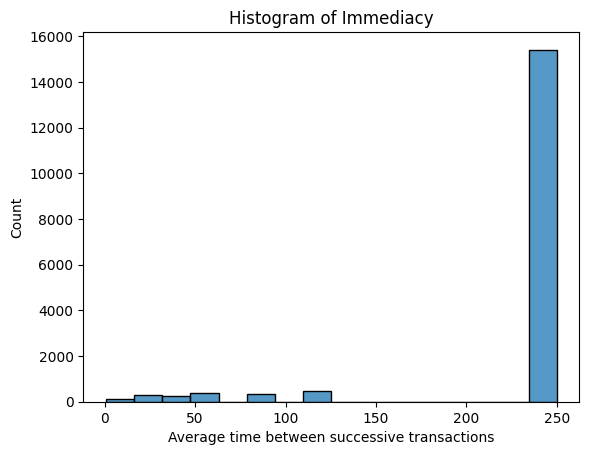

In [46]:
sns.histplot(intensity.immediacy_lag_1)
plt.title("Histogram of Immediacy")
plt.xlabel("Average time between successive transactions")

### 8. Total Volume Transacted

In [47]:
lag = "250ms"

temp = df2_1.copy()
temp = temp.set_index('datetime_ms')
temp = temp[['amount']].resample(lag).sum().shift(1).reset_index()
temp = temp.rename(columns={'amount':'totVol_lag_1', 'datetime_ms':'T'})

In [48]:
## construct lagged values (have to be done before as_of merge)
for i in range(2,11):
    s = 'totVol_lag_' + str(i)
    temp[s] = temp['totVol_lag_1'].shift(i-1)
## remove NaN
temp = temp.iloc[10:]

In [49]:
total_vol = pd.merge_asof(target, temp, on='T')
## define feature table
total_vol = total_vol.drop('return', axis=1)

Text(0.5, 1.0, 'Histogram of Total Volume (lookback 250ms)')

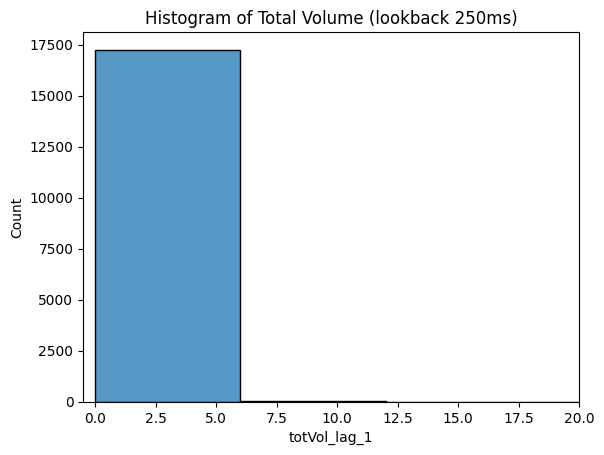

In [50]:
sns.histplot(total_vol.totVol_lag_1)
plt.xlim(-0.5,20)
plt.title("Histogram of Total Volume (lookback 250ms)")

### 9. Maximum Volume Transacted

In [51]:
lag = "250ms"

temp = df2_1.copy()
temp = temp.set_index('datetime_ms')
temp = temp[['amount']].resample(lag).max().shift(1).reset_index()
temp = temp.rename(columns={'amount':'maxVol_lag_1', 'datetime_ms':'T'})

In [52]:
temp = temp.iloc[1:]
temp = temp.fillna(0)

In [53]:
## construct lagged values (have to be done before as_of merge)
for i in range(2,11):
    s = 'maxVol_lag_' + str(i)
    temp[s] = temp['maxVol_lag_1'].shift(i-1)
## remove NaN
temp = temp.iloc[9:]

In [54]:
max_vol = pd.merge_asof(target, temp, on='T')
## define feature table
max_vol = max_vol.drop('return', axis=1)

Text(0.5, 1.0, 'Histogram of Max Volume (lookback 250ms)')

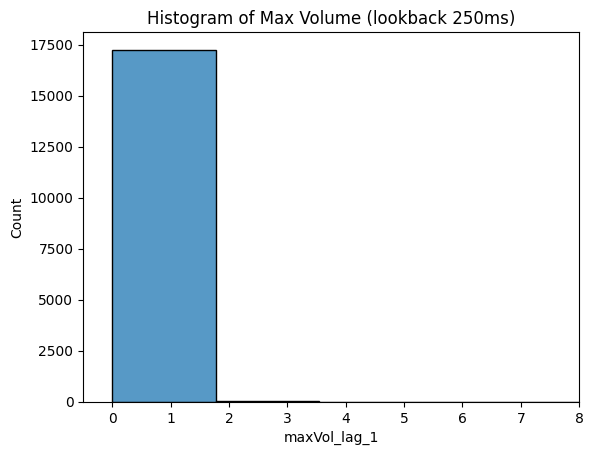

In [55]:
sns.histplot(max_vol.maxVol_lag_1)
plt.xlim(-0.5,8)
plt.title("Histogram of Max Volume (lookback 250ms)")

### 10. Average Volume Transacted

In [56]:
avg_vol = target.reset_index(drop=True).copy()
for i in range(1,11):
    g1 = 'avgVol_lag_'+str(i)
    g2 = 'totVol_lag_'+str(i)
    g3 = 'numTrade_lag_'+str(i)
    avg_vol[g1] = total_vol[g2]/intensity[g3]

In [57]:
# fill NaN with zeros (zero trading)
avg_vol = avg_vol.fillna(0)
## define feature table
avg_vol = avg_vol.drop('return', axis=1)

## Data preparation for Modelling

### 1. Putting together target values and all features

In [58]:
data = target.merge(transaction_imbalance, how='left', on='T')
data = data.merge(past_return, how='left', on='T')
data = data.merge(lob_imbalance, how='left', on='T')
data = data.merge(px_change_rel_vol, how='left', on='T')
data = data.merge(quoted_spread, how='left', on='T')
data = data.merge(intensity, how='left', on='T')
data = data.merge(total_vol, how='left', on='T')
data = data.merge(max_vol, how='left', on='T')
data = data.merge(avg_vol, how='left', on='T')

In [59]:
# check for null
data.isnull().values.any()

False

In [60]:
# check infinity
np.isinf(data).values.sum()

0

### 2. Train-validation-test Split

In [61]:
# dont run more than once
data = data.drop("T", axis=1)

## 70% training, 30% testing
df_train = data.iloc[:12096]
df_test = data.iloc[12096:]

In [62]:
X = df_train.drop("return", axis=1)
y = df_train['return']

X_test = df_test.drop("return", axis=1)
y_test = df_test['return']

from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=0, shuffle=False)

### 3. Winsorisation

In [63]:
def clip_series(s, lower, upper):
   clipped = s.clip(lower=s.quantile(lower), upper=s.quantile(upper))
   return clipped

# Manage list of features to be winsorized
feature_list = list(X_train.columns)

for f in feature_list:
   X_train[f] = clip_series(X_train[f], 0.05, 0.95)

### 4. Standardise Columns

In [101]:
# can't standardise everything because some columns have very small standard deviation
m1 = ['txn_imbalance_lag_1', 'txn_imbalance_lag_2', 'txn_imbalance_lag_3', 'txn_imbalance_lag_4', 'txn_imbalance_lag_5', 'txn_imbalance_lag_6', 'txn_imbalance_lag_7', 'txn_imbalance_lag_8', 'txn_imbalance_lag_9', 'txn_imbalance_lag_10']
m2 = ['past_return_lag_1', 'past_return_lag_2', 'past_return_lag_3', 'past_return_lag_4', 'past_return_lag_5', 'past_return_lag_6', 'past_return_lag_7', 'past_return_lag_8', 'past_return_lag_9', 'past_return_lag_10']
X_train_2 = X_train.drop(m1+m2, axis=1)
X_valid_2 = X_valid.drop(m1+m2, axis=1)
X_test_2 = X_test.drop(m1+m2, axis=1)

## standardising using statistics from training set only
X_train_1 = (X_train_2 - X_train_2.mean())/X_train_2.std()
X_valid_1 = (X_valid_2 - X_train_2.mean())/X_train_2.std()
X_test_1 = (X_test_2 - X_train_2.mean())/X_train_2.std()

X_train_1[m1+m2] = X_train[m1+m2]
X_valid_1[m1+m2] = X_valid[m1+m2]
X_test_1[m1+m2] = X_test[m1+m2]

### 5. Combined X_train and X_valid (after hyperparameter tuning to predict on X_test_1)

In [102]:
## Predict X_test using both X_train and X_valid
X_1 = X.copy()

# Winsorisation
feature_list = list(X_1.columns)

for f in feature_list:
   X_1[f] = clip_series(X_1[f], 0.05, 0.95)

In [103]:
## standardising using statistics from training set only
X_2 = X_1.drop(m1+m2, axis=1)
X_combined_test_2 = X_test.drop(m1+m2, axis=1)

X_1 = (X_2 - X_2.mean())/X_2.std()
X_combined_test_1 = (X_combined_test_2 - X_2.mean())/X_2.std()

X_1[m1+m2] = X[m1+m2]
X_combined_test_1[m1+m2] = X_test[m1+m2]

### 6. Visualise distribution of features

Text(0.5, 1.0, 'Histogram of lambda (after standardisation and winsorisation)')

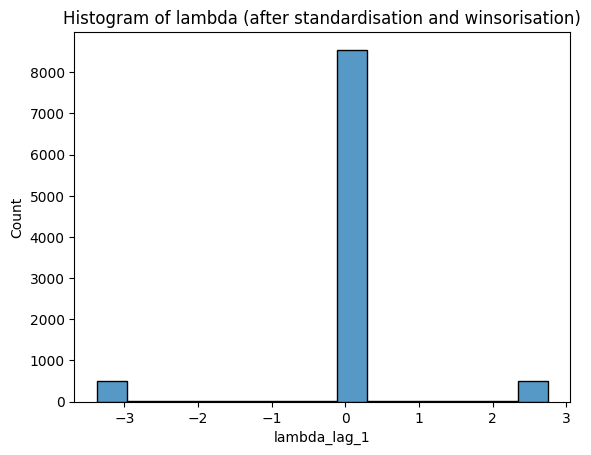

In [67]:
sns.histplot(X_train_1['lambda_lag_1'])
plt.title("Histogram of lambda (after standardisation and winsorisation)")

Text(0.5, 1.0, 'Histogram of quoted spread (after standardisation and winsorisation)')

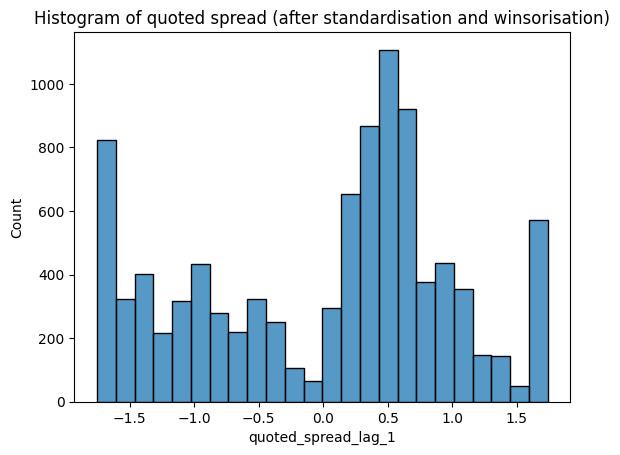

In [68]:
sns.histplot(X_train_1['quoted_spread_lag_1'])
plt.title("Histogram of quoted spread (after standardisation and winsorisation)")

Text(0.5, 1.0, 'Histogram of Total Volume (after standardisation and winsorisation)')

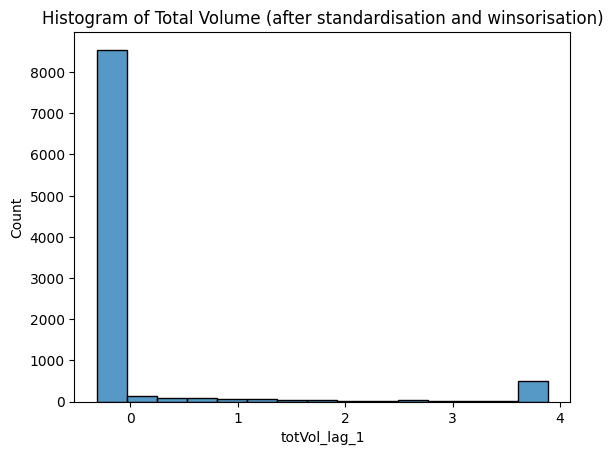

In [69]:
sns.histplot(X_train_1['totVol_lag_1'])
plt.title("Histogram of Total Volume (after standardisation and winsorisation)")

Text(0.5, 1.0, 'Histogram of Average Volume (after standardisation and winsorisation)')

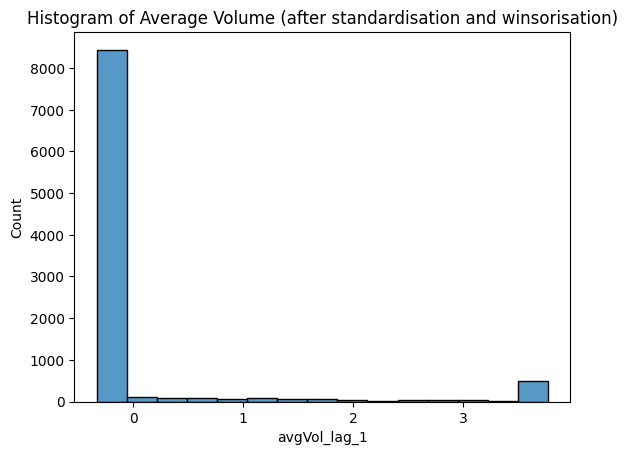

In [70]:
sns.histplot(X_train_1['avgVol_lag_1'])
plt.title("Histogram of Average Volume (after standardisation and winsorisation)")

Text(0.5, 1.0, 'Histogram of Maximum Volume (after standardisation and winsorisation)')

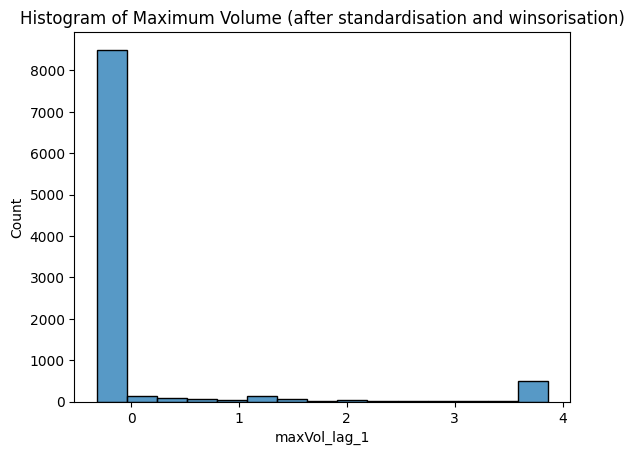

In [71]:
sns.histplot(X_train_1['maxVol_lag_1'])
plt.title("Histogram of Maximum Volume (after standardisation and winsorisation)")

Text(0.5, 1.0, 'Histogram of numTrade (after standardisation and winsorisation)')

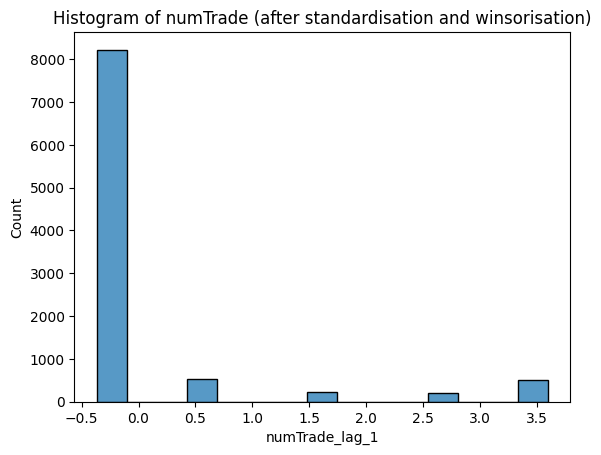

In [72]:
sns.histplot(X_train_1['numTrade_lag_1'])
plt.title("Histogram of numTrade (after standardisation and winsorisation)")

Text(0.5, 1.0, 'Histogram of Immediacy (after standardisation and winsorisation)')

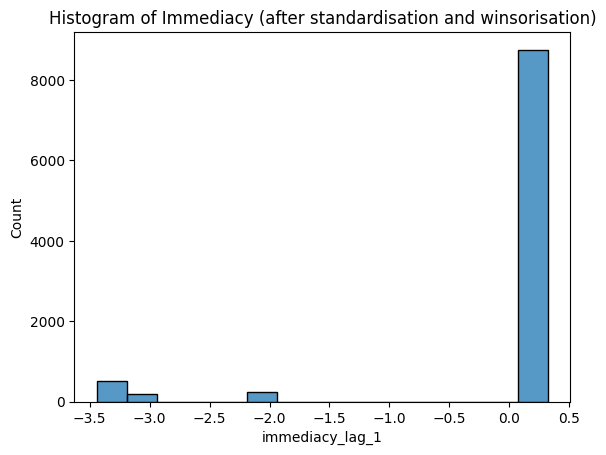

In [73]:
sns.histplot(X_train_1['immediacy_lag_1'])
plt.title("Histogram of Immediacy (after standardisation and winsorisation)")

## Modelling

### 1. OLS

In [104]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

reg = LinearRegression().fit(X_1, y)
# reg.score(X_1, y)
y_pred_test = reg.predict(X_combined_test_1)
print(f"r^2 on Test Set: {r2_score(y_pred_test, y_test)}")


r^2 on Test Set: -0.003378618453422577


### 2. Lasso

In [105]:
from sklearn.linear_model import Lasso
from sklearn.metrics import r2_score

alpha = 0.5
lasso = Lasso(alpha=alpha)

y_pred_lasso = lasso.fit(X_train_1, y_train).predict(X_valid_1)
print(f"alpha = {alpha} -> R squared on validation set: {r2_score(y_valid, y_pred_lasso)}")

alpha = 0.5 -> R squared on validation set: -0.0012847451731674564


#### 2.1 Hyperparameter tuning

In [106]:
a = [0.00000001, 0.0000001, 0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000, 100000, 1000000]

for i in a:
    alpha = i
    lasso = Lasso(alpha=alpha)
    y_pred_lasso = lasso.fit(X_train_1, y_train).predict(X_valid_1)
    print(f"alpha = {i} -> R squared on validation set: {r2_score(y_valid, y_pred_lasso)}")

alpha = 1e-08 -> R squared on validation set: -135.42930518378216
alpha = 1e-07 -> R squared on validation set: -75.06882823439746
alpha = 1e-06 -> R squared on validation set: -2.9063806919430153
alpha = 1e-05 -> R squared on validation set: 0.035838894847092795
alpha = 0.0001 -> R squared on validation set: -0.0012847451731674564
alpha = 0.001 -> R squared on validation set: -0.0012847451731674564
alpha = 0.01 -> R squared on validation set: -0.0012847451731674564
alpha = 0.1 -> R squared on validation set: -0.0012847451731674564
alpha = 1 -> R squared on validation set: -0.0012847451731674564
alpha = 10 -> R squared on validation set: -0.0012847451731674564
alpha = 100 -> R squared on validation set: -0.0012847451731674564
alpha = 1000 -> R squared on validation set: -0.0012847451731674564
alpha = 10000 -> R squared on validation set: -0.0012847451731674564
alpha = 100000 -> R squared on validation set: -0.0012847451731674564
alpha = 1000000 -> R squared on validation set: -0.001284

In [109]:
alpha = 0.00001
lasso = Lasso(alpha=alpha)
y_pred_lasso = lasso.fit(X_1, y).predict(X_combined_test_1)
print(f"alpha = {alpha} -> R squared on test set: {r2_score(y_test, y_pred_lasso)}")

alpha = 1e-05 -> R squared on test set: 0.04172163894843406


In [110]:
import eli5
eli5.show_weights(lasso, top=-1, feature_names = X_1.columns.tolist())

Weight?,Feature
+0.000,<BIAS>
-0.000,lob_imb_lag_1


### 3. Random Forest

In [111]:
from sklearn.ensemble import RandomForestRegressor

In [112]:
## hyperparamter tuning max depth
for i in range(2,8):
    regr = RandomForestRegressor(n_estimators=100, max_depth=i, random_state=0)
    regr.fit(X_train_1, y_train)
    y_valid_pred = regr.predict(X_valid_1)
    r2_score_rf = r2_score(y_valid, y_valid_pred)
    print(f"max depth = {i} -> r^2 on validation data = {r2_score_rf:.5f}")

max depth = 2 -> r^2 on validation data = 0.04812
max depth = 3 -> r^2 on validation data = 0.05050
max depth = 4 -> r^2 on validation data = 0.04984
max depth = 5 -> r^2 on validation data = 0.04584
max depth = 6 -> r^2 on validation data = 0.04257
max depth = 7 -> r^2 on validation data = 0.03775


In [113]:
regr = RandomForestRegressor(n_estimators=100, max_depth=3, random_state=0)
regr.fit(X_1, y)

y_test_pred = regr.predict(X_combined_test_1)
r2_score_rf = r2_score(y_test, y_test_pred)
print("r^2 on Test Set : %f" % r2_score_rf)

r^2 on Test Set : 0.045912


#### 3.1 Feature Importance

Text(0.5, 0, 'Random Forest Feature Importance')

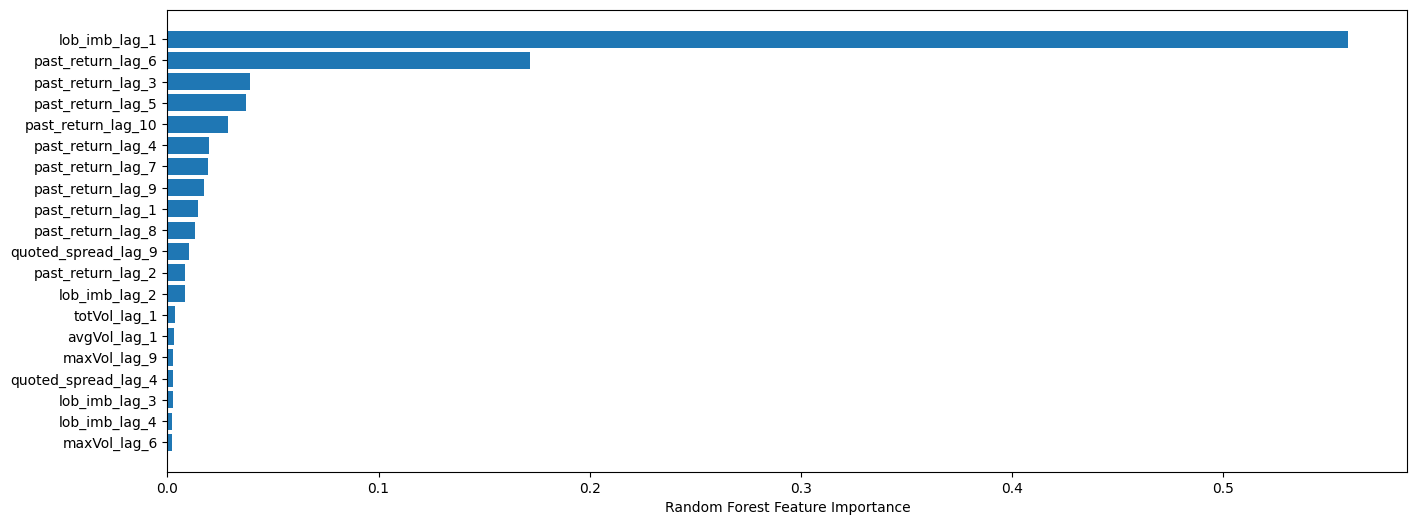

In [114]:
sorted_idx = regr.feature_importances_.argsort()
plt.figure(figsize=(16,6))
plt.barh(X_1.columns[sorted_idx][80:], regr.feature_importances_[sorted_idx][80:])
plt.xlabel("Random Forest Feature Importance")

### 4. XGBoost

In [115]:
from xgboost import XGBRegressor

my_model = XGBRegressor(n_estimators=500, learning_rate=0.3, early_stopping_rounds=5)
my_model.fit(X_train_1, y_train,
             eval_set=[(X_valid_1, y_valid)], 
             verbose=False)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=5, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.3, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=500, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)

In [116]:
xgb_y_pred = my_model.predict(X_test_1)
r2_score_xgb = r2_score(y_test, xgb_y_pred)
print("r^2 on Test Set : %f" % r2_score_xgb)

r^2 on Test Set : 0.035929


In [121]:
my_model = XGBRegressor(n_estimators=500, learning_rate=0.05, max_depth=6)
my_model.fit(X_1, y, 
             verbose=False)

xgb_y_pred = my_model.predict(X_combined_test_1)
r2_score_xgb = r2_score(y_test, xgb_y_pred)
print("r^2 on Test Set : %f" % r2_score_xgb)

r^2 on Test Set : 0.042085
